# WEB SCRAPPING FOR AMAZON, WALMART LAPTOPS FROM https://serpapi.com

In [5]:
SERPAPI_API_KEY='67be15bb4fc5f7ffb97034439f32b82f125a52be1bccc0422904b4aad1de3d0f' #insert serpapi key

## IMPORT LIBRARIES

In [6]:
import requests
import pandas as pd
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from datetime import datetime
import warnings
import random
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## AMAZON DATA COLLECTION 

In [118]:
# ==================== AMAZON DATA COLLECTION ====================

def search_amazon(query, max_pages=4, items_per_page=12):
    """
    Optimized Amazon search with better pagination and error handling.
    Targets maximum product extraction.
    """
    all_products = []
    
    print(f"  Searching: '{query}'")
    
    for page in range(1, max_pages + 1):
        print(f"    Page {page}/{max_pages}", end="")
        
        params = {
            "api_key": SERPAPI_API_KEY,
            "engine": "amazon",
            "k": query,
            "page": str(page),
            "num": "12"  # Request more results per page
        }
        
        # Add randomized delays to avoid rate limiting
        time.sleep(random.uniform(1.5, 3.0))
        
        try:
            response = requests.get("https://serpapi.com/search", 
                                  params=params, 
                                  timeout=25)
            
            if response.status_code == 200:
                data = response.json()
                products = data.get('organic_results', [])
                
                # Extract ALL products, not just limited subset
                for product in products:
                    product_data = extract_product_data_improved(product)
                    product_data['search_query'] = query
                    product_data['page_fetched'] = page
                    all_products.append(product_data)
                
                print(" ✅")
                
                # If no products returned, stop pagination
                if len(products) == 0:
                    print(f"    No more products, stopping at page {page}")
                    break
                    
            else:
                print(f" ❌ HTTP {response.status_code}")
                if response.status_code == 429:  # Rate limited
                    print("    Rate limited, waiting 5 seconds...")
                    time.sleep(5)
                
        except Exception as e:
            print(f" ❌ Error: {str(e)[:50]}")
            # Continue to next page even if one fails
    
    print(f"    Collected: {len(all_products)} products")
    return all_products

def collect_amazon_laptops_comprehensive():
    """
    Comprehensive Amazon laptop collection with strategic search queries.
    Targets 500+ unique products.
    """
    print("=" * 70)
    print("COMPREHENSIVE AMAZON LAPTOP COLLECTION")
    print("=" * 70)
    
    # ========== STRATEGIC SEARCH QUERY EXPANSION ==========
    # 4 categories of searches for maximum coverage
    search_strategies = {
        # CATEGORY 1: Core laptop types (6 queries × 4 pages = ~240 products)
        "core_types": [
            "gaming laptop", "business laptop", "student laptop",
            "2-in-1 laptop", "Chromebook", "ultrabook"
        ],
        
        # CATEGORY 2: Brand-focused (7 queries × 3 pages = ~210 products)
        "brand_focused": [
            "Apple MacBook", "Dell XPS laptop", "HP Pavilion laptop",
            "Lenovo ThinkPad", "ASUS ROG laptop", "Acer Aspire laptop",
            "Microsoft Surface laptop"
        ],
        
        # CATEGORY 3: Spec-focused (6 queries × 3 pages = ~180 products)
        "spec_focused": [
            "laptop 16GB RAM", "laptop 32GB RAM", "laptop 1TB SSD",
            "laptop RTX 4060", "laptop Intel i7", "laptop AMD Ryzen 7"
        ],
        
        # CATEGORY 4: Price/Deal focused (6 queries × 3 pages = ~180 products)
        "deal_focused": [
            "laptop under $500", "laptop under $800", "laptop under $1000",
            "refurbished laptop", "renewed laptop", "laptop deals 2024"
        ],
        
        # CATEGORY 5: Use-case focused (5 queries × 3 pages = ~150 products)
        "usecase_focused": [
            "programming laptop", "video editing laptop", "graphic design laptop",
            "college laptop", "work from home laptop"
        ]
    }
    
    all_products = []
    total_queries = sum(len(queries) for queries in search_strategies.values())
    
    print(f"📋 Search Strategy: {total_queries} queries across 5 categories")
    print(f"🎯 Target: 500+ unique laptop products")
    print(f"⏱️  Estimated time: 15-20 minutes")
    print("-" * 70)
    
    query_count = 1
    
    # Execute each category with optimized pagination
    for category_name, queries in search_strategies.items():
        print(f"\n📂 CATEGORY: {category_name.upper()}")
        print("-" * 40)
        
        for query in queries:
            print(f"\n{query_count:2d}. Query: '{query}'")
            
            # Dynamic pagination based on query type
            if "under" in query.lower() or "deal" in query.lower():
                pages = 4  # More pages for budget/deal searches
            elif "gaming" in query.lower():
                pages = 4  # Gaming has many products
            else:
                pages = 3  # Default
            
            products = search_amazon(query, max_pages=pages, items_per_page=12)
            all_products.extend(products)
            
            current_total = len(all_products)
            print(f"   Running total: {current_total} products")
            
            query_count += 1
    
    # ========== CREATE DATAFRAME AND DEDUPLICATE ==========
    print("\n" + "=" * 70)
    print("DATA PROCESSING")
    print("=" * 70)
    
    if not all_products:
        print("❌ No data collected.")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_products)
    initial_count = len(df)
    print(f"Raw products collected: {initial_count}")
    
    # Enhanced deduplication
    print("\n🧹 Removing duplicates...")
    
    # 1. Remove by ASIN (Amazon's unique ID)
    df = df.drop_duplicates(subset=['asin'], keep='first')
    print(f"   After ASIN dedup: {len(df)} products")
    
    # 2. Remove by title similarity
    df['title_clean'] = df['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    df = df.drop_duplicates(subset=['title_clean'], keep='first')
    print(f"   After title dedup: {len(df)} products")
    
    # 3. Remove products without price
    df = df[df['extracted_price'] > 10]
    print(f"   After price filter: {len(df)} products")
    
    duplicates_removed = initial_count - len(df)
    print(f"\n✅ Final unique products: {len(df)} (removed {duplicates_removed} duplicates)")
    
    # ========== ENHANCE DATA QUALITY ==========
    print("\n📊 ENHANCING DATA QUALITY...")
    
    # Extract brand from title if missing
    def extract_brand_from_title(title):
        if not isinstance(title, str):
            return "Unknown"
        
        title_lower = title.lower()
        brand_patterns = {
            'Apple': ['apple', 'macbook', 'mac '],
            'HP': ['hp ', 'hp-', 'pavilion', 'envy', 'spectre', 'omen'],
            'Dell': ['dell', 'xps', 'inspiron', 'alienware', 'latitude'],
            'Lenovo': ['lenovo', 'thinkpad', 'ideapad', 'yoga', 'legion'],
            'ASUS': ['asus', 'rog ', 'tuf ', 'zenbook'],
            'Acer': ['acer', 'aspire', 'predator', 'nitro'],
            'MSI': ['msi', 'msi '],
            'Microsoft': ['microsoft', 'surface'],
            'Samsung': ['samsung', 'galaxy book']
        }
        
        for brand, keywords in brand_patterns.items():
            for keyword in keywords:
                if keyword in title_lower:
                    return brand
        return "Unknown"
    
    df['brand_enhanced'] = df.apply(
        lambda row: row['brand'] if row['brand'] != 'N/A' else extract_brand_from_title(row['title']),
        axis=1
    )
    
    # ========== SAVE RESULTS ==========
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    
    # Save full dataset
    full_filename = f"amazon_laptops_full_{timestamp}.csv"
    df.to_csv(full_filename, index=False)
    
    
    # ========== DISPLAY SUMMARY ==========
    print("\n" + "=" * 70)
    print("📈 COLLECTION SUMMARY")
    print("=" * 70)
    
    print(f"🎯 TARGET ACHIEVED: {'✅' if len(df) >= 500 else '⚠️ '}")
    print(f"📦 Unique products: {len(df)}")
    print(f"💰 Average price: ${df['extracted_price'].mean():.2f}")
    print(f"⭐ Products with ratings: {df[df['rating'] != 'N/A'].shape[0]}")
    
    print(f"\n🏷️ TOP 5 BRANDS:")
    top_brands = df['brand_enhanced'].value_counts().head(5)
    for brand, count in top_brands.items():
        percentage = (count / len(df)) * 100
        print(f"  {brand}: {count} products ({percentage:.1f}%)")
    
    print(f"\n🔍 SEARCH CATEGORY PERFORMANCE:")
    for category, queries in search_strategies.items():
        category_products = df[df['search_query'].isin(queries)]
        print(f"  {category}: {len(category_products)} products")
    
    print(f"\n💾 Files saved:")
    print(f"  • {full_filename} - Full dataset")
    
    
    return df
    
  # ==================== EXECUTION ====================
if __name__ == "__main__":
    print("\n🚀 STARTING COMPREHENSIVE AMAZON DATA COLLECTION")
    print("Estimated API calls: ~90")
    print("Estimated products: 500+")
    print("-" * 70)
    
    try:
        amazon_df = collect_amazon_laptops_comprehensive()
        
        if not amazon_df.empty:
            print("\n" + "=" * 70)
            print("✅ AMAZON COLLECTION COMPLETE!")
            print("=" * 70)
                
        else:
            print("\n❌ Collection failed.")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")  


🚀 STARTING COMPREHENSIVE AMAZON DATA COLLECTION
Estimated API calls: ~90
Estimated products: 500+
----------------------------------------------------------------------
COMPREHENSIVE AMAZON LAPTOP COLLECTION
📋 Search Strategy: 30 queries across 5 categories
🎯 Target: 500+ unique laptop products
⏱️  Estimated time: 15-20 minutes
----------------------------------------------------------------------

📂 CATEGORY: CORE_TYPES
----------------------------------------

 1. Query: 'gaming laptop'
  Searching: 'gaming laptop'
 ✅  Page 1/4
 ✅  Page 2/4
 ✅  Page 3/4
 ✅  Page 4/4
    Collected: 76 products
   Running total: 76 products

 2. Query: 'business laptop'
  Searching: 'business laptop'
 ✅  Page 1/3
 ✅  Page 2/3
 ✅  Page 3/3
    Collected: 60 products
   Running total: 136 products

 3. Query: 'student laptop'
  Searching: 'student laptop'
 ✅  Page 1/3
 ✅  Page 2/3
 ✅  Page 3/3
    Collected: 54 products
   Running total: 190 products

 4. Query: '2-in-1 laptop'
  Searching: '2-in-1 lapt

# Amazon BRAND NAME EXTRACTION FROM TITLE

In [69]:
amazon_df = pd.read_csv('amazon_laptops_full_20251216_2009.csv')

In [70]:
amazon_df.brand.unique()

array([nan, 'Acer', 'ASUS', 'HP', 'Lenovo', 'MSI', 'Dell', 'Apple',
       'Samsung', 'Microsoft', 'Macally', 'MOSISO', 'UESWILL', 'GHU',
       'TSKYBEAR', 'EXCaliberPC', 'acer', 'Machenike', 'Batianda', 'NIMO'],
      dtype=object)

In [71]:
def extract_brand_from_title(title, existing_brand):
    """
    Extract brand from product title, prioritizing existing brand info when available.
    
    Args:
        title (str): Product title
        existing_brand (str): Brand value already in the brand column
    
    Returns:
        str: Extracted brand name
    """
    # If brand is already provided and not N/A, use it
    if isinstance(existing_brand, str) and existing_brand != 'N/A' and existing_brand.strip():
        return existing_brand.strip()
    
    # If title is not a string, return N/A
    if not isinstance(title, str):
        return 'N/A'
    
    title_lower = title.lower()
    
    # Updated brand patterns based on your data
    brand_patterns = {
        'Apple': ['apple', 'macbook', 'mac '],
        'ASUS': ['asus', 'rog', 'tuf', 'zenbook'],
        'Dell': ['dell', 'xps', 'inspiron', 'alienware', 'latitude'],
        'HP': ['hp', 'pavilion', 'envy', 'spectre', 'omen', 'elitebook', 'probook'],
        'Lenovo': ['lenovo', 'thinkpad', 'ideapad', 'yoga', 'legion'],
        'Acer': ['acer', 'aspire', 'predator', 'nitro', 'swift'],
        'MSI': ['msi'],
        'Microsoft': ['microsoft', 'surface'],
        'Samsung': ['samsung', 'galaxy book'],
        'Razer': ['razer', 'blade'],
        'Gigabyte': ['gigabyte', 'aorus'],
        'NIMO': ['nimo', 'NIMO'],  # Found in your data
        'EYY': ['eyy'],    # Found in your data
        'SIECUBIC': ['siecubic'],  # Found in your data
        'fanxiang': ['fanxiang'],  # Found in your data
    }
    
    # Check for brand patterns
    for brand, keywords in brand_patterns.items():
        for keyword in keywords:
            # Add word boundaries to avoid partial matches
            if f' {keyword}' in title_lower or title_lower.startswith(keyword):
                return brand
    
    # Check for uppercase brand names (common in titles)
    words = title.split()
    for word in words:
        # Look for all-caps words that might be brands
        if word.isupper() and len(word) > 2:
            potential_brand = word.title()
            if potential_brand in brand_patterns:
                return potential_brand
    
    return 'N/A'

# Apply the improved function
amazon_df['brand_extracted'] = amazon_df.apply(
    lambda row: extract_brand_from_title(row['title'], row['brand']), 
    axis=1
)

# Create a combined brand column that uses extracted brand if brand is N/A
amazon_df['brand_final'] = amazon_df.apply(
    lambda row: row['brand_extracted'] if row['brand'] == 'N/A' else row['brand'],
    axis=1
)

print(f"✅ Brands extracted from titles: {len(amazon_df[amazon_df['brand_extracted'] != 'N/A'])} products")
print(f"✅ Total products with brand info (combined): {len(amazon_df[amazon_df['brand_final'] != 'N/A'])}")
print("\nFinal brands distribution:")
print(amazon_df['brand_final'].value_counts().head(20))

# Show some examples of brand extraction
print("\n\nSample brand extractions:")
sample_df = amazon_df[['title', 'brand', 'brand_extracted', 'brand_final']].head(10)
for idx, row in sample_df.iterrows():
    print(f"\nTitle: {row['title'][:80]}...")
    print(f"Original brand: {row['brand']} -> Extracted: {row['brand_extracted']} -> Final: {row['brand_final']}")

# Calculate improvement
original_with_brand = len(amazon_df[amazon_df['brand'] != 'N/A'])
final_with_brand = len(amazon_df[amazon_df['brand_final'] != 'N/A'])
improvement = final_with_brand - original_with_brand

print(f"\n📊 Summary:")
print(f"Original data had brand info for: {original_with_brand} products")
print(f"After extraction: {final_with_brand} products")
print(f"Added brand info for: {improvement} additional products")

✅ Brands extracted from titles: 874 products
✅ Total products with brand info (combined): 943

Final brands distribution:
brand_final
HP             288
Lenovo         145
Dell           128
ASUS            90
Apple           59
Microsoft       38
Acer            33
acer            30
MSI             26
Samsung          3
EXCaliberPC      1
Batianda         1
Machenike        1
Macally          1
TSKYBEAR         1
GHU              1
UESWILL          1
MOSISO           1
NIMO             1
Name: count, dtype: int64


Sample brand extractions:

Title: NIMO 15.6" FHD Light-Gaming-Laptop, 8 Cores AMD Ryzen 7 Pro 6850U 32GB LPDDR5 RA...
Original brand: nan -> Extracted: NIMO -> Final: nan

Title: NIMO 15.6" IPS FHD-Gaming-Laptop,AMD Ryzen 5 6600H 16GB DDR5 RAM 512GB SSD (Beat...
Original brand: nan -> Extracted: NIMO -> Final: nan

Title: acer Nitro V 15.6” FHD IPS 165Hz Gaming Laptop|Intel Core i5-13420H|NVIDIA GeFor...
Original brand: Acer -> Extracted: Acer -> Final: Acer

Title: NIMO 1

In [41]:
amazon_df.head(3)

,position,asin,sponsored,brand,title,rating,reviews,price,extracted_price,old_price,...,specs_os,link_clean,title_lower,search_query,page_fetched,title_clean,brand_enhanced,brand_extracted,brand_final,source
0,1,B0FPR91V6L,False,NaN,"NIMO 15.6"" FHD Light-Gaming-Laptop, 8 Cores AM...",4.5,203.0,$599.99,599.99,NaN,...,Windows 11,https://www.amazon.com/NIMO-Light-Gaming-Lapto...,"nimo 15.6"" fhd light-gaming-laptop, 8 cores am...",gaming laptop,1,nimo 156 fhd lightgaminglaptop 8 cores amd ryz...,Unknown,NIMO,NaN,Amazon
1,2,B0FWRKTF8B,False,NaN,"NIMO 15.6"" IPS FHD-Gaming-Laptop,AMD Ryzen 5 6...",4.4,76.0,$499.99,499.99,NaN,...,Windows 11,https://www.amazon.com/NIMO-FHD-Gaming-Laptop-...,"nimo 15.6"" ips fhd-gaming-laptop,amd ryzen 5 6...",gaming laptop,1,nimo 156 ips fhdgaminglaptopamd ryzen 5 6600h ...,Unknown,NIMO,NaN,Amazon
2,3,B0G42XBNCR,False,Acer,acer Nitro V 15.6” FHD IPS 165Hz Gaming Laptop...,NaN,NaN,$879.99,879.99,NaN,...,Windows 11 Home,https://www.amazon.com/acer-Nitro-i5-13420H-Ge...,acer nitro v 15.6” fhd ips 165hz gaming laptop...,gaming laptop,1,acer nitro v 156 fhd ips 165hz gaming laptopin...,Acer,Acer,Acer,Amazon


## WALMART DATASET


In [9]:

# ==================== CONFIGURATION ====================
SERPAPI_API_KEY = SERPAPI_API_KEY  


# ==================== DATA EXTRACTION FUNCTION ====================
def extract_walmart_product_data(product):
    """
    Extract product data from Walmart API response.
    Returns data in a consistent format for analysis.
    """
    # Get primary offer info
    primary_offer = product.get('primary_offer', {})
    
    # Extract prices
    offer_price = primary_offer.get('offer_price', 0)
    was_price = primary_offer.get('was_price', 0)
    
    # Convert string prices to float
    try:
        if isinstance(offer_price, str):
            offer_price = float(offer_price.replace('$', '').replace(',', ''))
    except:
        offer_price = 0
    
    try:
        if isinstance(was_price, str):
            was_price = float(was_price.replace('$', '').replace(',', ''))
    except:
        was_price = 0
    
    # Get title and brand
    title = product.get('title', 'N/A')
    brand = product.get('brand', 'N/A')
    
    # Extract brand from title if not provided
    if brand in ['Not specified', 'N/A', None, '']:
        brand_keywords = {
            'Apple': ['apple', 'macbook', 'mac '],
            'Dell': ['dell', 'xps', 'inspiron', 'alienware'],
            'HP': ['hp ', 'hp-', 'pavilion', 'envy', 'spectre', 'omen'],
            'Lenovo': ['lenovo', 'thinkpad', 'ideapad', 'yoga', 'legion'],
            'ASUS': ['asus', 'rog ', 'tuf ', 'zenbook'],
            'Acer': ['acer', 'aspire', 'predator', 'nitro'],
            'MSI': ['msi', 'msi '],
            'Microsoft': ['microsoft', 'surface'],
            'Samsung': ['samsung', 'galaxy book'],
            'Google': ['google', 'pixelbook'],
            'Razer': ['razer', 'blade']
        }
        
        title_lower = title.lower()
        for brand_name, keywords in brand_keywords.items():
            for keyword in keywords:
                if keyword in title_lower:
                    brand = brand_name
                    break
            if brand != 'N/A':
                break
    
    # Extract shipping info
    free_shipping = product.get('free_shipping', False)
    
    # Try to get seller info
    seller_info = product.get('seller', {})
    seller_name = seller_info.get('name', 'N/A') if seller_info else 'N/A'
    
    return {
        'source': 'Walmart',
        'item_id': product.get('us_item_id', 'N/A'),  # Walmart's unique ID
        'position': product.get('position', 'N/A'),
        'brand': brand,
        'title': title,
        'rating': product.get('rating', 'N/A'),
        'reviews': product.get('reviews', 'N/A'),
        'price': f"${offer_price:.2f}" if offer_price > 0 else 'N/A',
        'extracted_price': offer_price,
        'old_price': f"${was_price:.2f}" if was_price > 0 else 'N/A',
        'extracted_old_price': was_price,
        'free_shipping': free_shipping,
        'in_stock': not product.get('out_of_stock', False),
        'seller': seller_name,
        'link': product.get('link', 'N/A'),
        'thumbnail': product.get('thumbnail', 'N/A')
    }

# ==================== SEARCH FUNCTION WITH PAGINATION ====================
def search_walmart_paginated(query, max_pages=3, items_per_page=12):
    """
    Search Walmart with pagination to get multiple pages of results.
    """
    all_products = []
    
    for page in range(1, max_pages + 1):
        print(f"  ↳ Page {page}", end="")
        
        params = {
            "api_key": SERPAPI_API_KEY,
            "engine": "walmart",
            "query": query,
            "page": str(page)
        }
        
        max_retries = 2
        success = False
        
        for attempt in range(max_retries + 1):
            try:
                # Increased timeout for reliability
                response = requests.get("https://serpapi.com/search", 
                                      params=params, 
                                      timeout=25)
                
                if response.status_code == 200:
                    data = response.json()
                    products = data.get('organic_results', [])
                    
                    for product in products[:items_per_page]:
                        product_data = extract_walmart_product_data(product)
                        product_data['search_query'] = query
                        product_data['page_fetched'] = page
                        all_products.append(product_data)
                    
                    success = True
                    break  # Exit retry loop on success
                    
                else:
                    if attempt < max_retries:
                        print(f" (retry {attempt+1})", end="")
                        time.sleep(3)
                    else:
                        print(f" ❌ HTTP {response.status_code}")
                        
            except requests.exceptions.Timeout:
                if attempt < max_retries:
                    print(f" (timeout, retry {attempt+1})", end="")
                    time.sleep(5)
                else:
                    print(" ❌ Timeout after retries")
                    break
            except Exception as e:
                if attempt < max_retries:
                    print(f" (error: {str(e)[:20]}..., retry {attempt+1})", end="")
                    time.sleep(3)
                else:
                    print(f" ❌ Error: {str(e)[:50]}")
                    break
        
        if success:
            print(" ✅")
        else:
            print(" ❌ Failed")
        
        # Delay between pages to be API-friendly
        if page < max_pages:
            time.sleep(2)
    
    return all_products
# ==================== SMART PAGINATION FUNCTION ====================
def smart_pagination(query):
    """Return appropriate page count based on query type"""
    query_lower = query.lower()
    
    if any(keyword in query_lower for keyword in ["under", "deal", "budget", "cheap", "sale"]):
        return 4  # More pages for budget/deals (more products)
    elif any(keyword in query_lower for keyword in ["gaming", "gamer", "rtx", "gtx"]):
        return 4  # Gaming has many products
    elif "apple" in query_lower or "macbook" in query_lower:
        return 2  # Apple has fewer but expensive products
    elif any(keyword in query_lower for keyword in ["chromebook", "2-in-1", "2 in 1"]):
        return 3  # Standard for niche categories
    else:
        return 3  # Default for other queries
        
# ==================== MAIN DATA COLLECTION FUNCTION ====================
def collect_all_walmart_laptops():
    """
    Main function to collect Walmart laptop data across multiple categories.
    Returns a pandas DataFrame with all collected data.
    """
    print("=" * 70)
    print("WALMART LAPTOP DATA COLLECTION")
    print("=" * 70)
    print(f"API Key: {'✓ Set' if SERPAPI_API_KEY != 'YOUR_SERPAPI_API_KEY_HERE' else '✗ NOT SET - PLEASE UPDATE LINE 7'}")
    print()
    
    if SERPAPI_API_KEY == "YOUR_SERPAPI_API_KEY_HERE":
        print("❌ ERROR: Please replace 'YOUR_SERPAPI_API_KEY_HERE' with your actual SerpApi key!")
        return pd.DataFrame()
    
    # Define search categories
    search_categories = [
        
            "gaming laptop", "business laptop", "student laptop",
            "2-in-1 laptop", "Chromebook", "ultrabook",
            "Apple MacBook", "Dell XPS laptop", "HP Pavilion laptop",
            "Lenovo ThinkPad", "ASUS ROG laptop", "Acer Aspire laptop",
            "Microsoft Surface laptop",
            "laptop 16GB RAM", "laptop 32GB RAM", "laptop 1TB SSD",
            "laptop RTX 4060", "laptop Intel i7", "laptop AMD Ryzen 7",
            "laptop under $500", "laptop under $800", "laptop under $1000",
            "refurbished laptop", "renewed laptop", "laptop deals 2024",
            "programming laptop", "video editing laptop", "graphic design laptop",
            "college laptop", "work from home laptop"]
    
    
    
    
    print(f"📋 Searching {len(search_categories)} categories:")
    print("-" * 40)
    
    all_products_data = []
    
    for i, category in enumerate(search_categories, 1):
        print(f"{i}. {category}")
        products = search_walmart_paginated(category, max_pages=3, items_per_page=10)
        all_products_data.extend(products)
        print(f"   Collected: {len(products)} products")
        print(f"   Running total: {len(all_products_data)} products")
        print()
    
    # Convert to DataFrame
    if not all_products_data:
        print("❌ No data collected. Check your API key and internet connection.")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_products_data)
    
    # Remove duplicates based on item_id
    initial_count = len(df)
    df = df.drop_duplicates(subset=['item_id'])
    df = df[df['item_id'] != 'N/A']
    duplicates_removed = initial_count - len(df)
    
    print("=" * 70)
    print("📊 DATA COLLECTION COMPLETE")
    print("=" * 70)
    
    print(f"📦 Products collected: {len(df)} (removed {duplicates_removed} duplicates)")
    
    if len(df) > 0:
        # Basic statistics
        price_data = df[df['extracted_price'] > 0]['extracted_price']
        rating_data = pd.to_numeric(df['rating'], errors='coerce').dropna()
        
        print(f"💰 Price range: ${price_data.min():.2f} - ${price_data.max():.2f}")
        print(f"💰 Average price: ${price_data.mean():.2f}")
        print(f"⭐ Average rating: {rating_data.mean():.2f}/5.0" if len(rating_data) > 0 else "⭐ No ratings available")
        print(f"🏷️  Unique brands: {df['brand'].nunique()}")
        print(f"🔍 Search categories: {df['search_query'].nunique()}")
        
        # Show top brands
        print("\n🏷️  TOP 5 BRANDS:")
        top_brands = df['brand'].value_counts().head(5)
        for brand, count in top_brands.items():
            percentage = (count / len(df)) * 100
            print(f"  {brand}: {count} products ({percentage:.1f}%)")
        
        # Show sample
        print("\n📋 SAMPLE OF COLLECTED DATA (first 3 products):")
        sample_cols = ['search_query', 'brand', 'title', 'price', 'rating', 'free_shipping']
        print(df[sample_cols].head(3).to_string(index=False))
        
        # Save to CSV
        filename = f"walmart_laptops_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.csv"
        df.to_csv(filename, index=False)
        print(f"\n💾 Data saved to: {filename}")
        
        # Save a clean version with selected columns
        clean_cols = ['search_query', 'item_id', 'brand', 'title', 'price', 
                     'extracted_price', 'old_price', 'rating', 'reviews', 
                     'free_shipping', 'in_stock', 'seller', 'link']
        df_clean = df[clean_cols].copy()
        clean_filename = f"walmart_laptops_clean_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.csv"
        df_clean.to_csv(clean_filename, index=False)
        print(f"💾 Clean version saved to: {clean_filename}")
    
    return df

# ==================== EXECUTION ====================
if __name__ == "__main__":
    # Run the data collection
    walmart_laptops_df = collect_all_walmart_laptops()
    
    # Quick verification
    if not walmart_laptops_df.empty:
        print("\n" + "=" * 70)
        print("✅ COLLECTION SUCCESSFUL")
        print(f"✅ Total laptops collected: {len(walmart_laptops_df)}")
        print("=" * 70)

WALMART LAPTOP DATA COLLECTION
API Key: ✓ Set

📋 Searching 30 categories:
----------------------------------------
1. gaming laptop
  ↳ Page 1 ✅
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 30 products

2. business laptop
 ✅↳ Page 1
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 60 products

3. student laptop
 ✅↳ Page 1
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 90 products

4. 2-in-1 laptop
 ✅↳ Page 1
  ↳ Page 2 (timeout, retry 1) ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 120 products

5. Chromebook
 ✅↳ Page 1
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 150 products

6. ultrabook
 ✅↳ Page 1
  ↳ Page 2 (timeout, retry 1) ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 180 products

7. Apple MacBook
 ✅↳ Page 1
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected: 30 products
   Running total: 210 products

8. Dell XPS laptop
 ✅↳ Page 1
  ↳ Page 2 ✅
  ↳ Page 3 ✅
   Collected

In [17]:
walmart_laptops_df.brand_final.unique()

array(['NIMO', 'N/A', 'ASUS', 'MSI', 'Acer', 'HP', 'Lenovo', 'Dell',
       'Samsung', 'Apple', 'Microsoft', 'Gigabyte'], dtype=object)

## WALMART BRAND NAME EXTRACTION FROM TITLE

In [27]:
def extract_brand_from_title(title, existing_brand):
    """
    Extract brand from product title, prioritizing existing brand info when available.
    
    Args:
        title (str): Product title
        existing_brand (str): Brand value already in the brand column
    
    Returns:
        str: Extracted brand name
    """
    # If brand is already provided and not N/A, use it
    if isinstance(existing_brand, str) and existing_brand != 'N/A' and existing_brand.strip():
        return existing_brand.strip()
    
    # If title is not a string, return N/A
    if not isinstance(title, str):
        return 'N/A'
    
    title_lower = title.lower()
    
    # Updated brand patterns based on your data
    brand_patterns = {
        'Apple': ['apple', 'macbook', 'mac '],
        'ASUS': ['asus', 'rog', 'tuf', 'zenbook'],
        'Dell': ['dell', 'xps', 'inspiron', 'alienware', 'latitude'],
        'HP': ['hp', 'pavilion', 'envy', 'spectre', 'omen', 'elitebook', 'probook'],
        'Lenovo': ['lenovo', 'thinkpad', 'ideapad', 'yoga', 'legion'],
        'Acer': ['acer', 'aspire', 'predator', 'nitro', 'swift'],
        'MSI': ['msi'],
        'Microsoft': ['microsoft', 'surface'],
        'Samsung': ['samsung', 'galaxy book'],
        'Razer': ['razer', 'blade'],
        'Gigabyte': ['gigabyte', 'aorus'],
        'NIMO': ['nimo', 'NIMO'],  # Found in your data
        'EYY': ['eyy'],    # Found in your data
        'SIECUBIC': ['siecubic'],  # Found in your data
        'fanxiang': ['fanxiang'],  # Found in your data
    }
    
    # Check for brand patterns
    for brand, keywords in brand_patterns.items():
        for keyword in keywords:
            # Add word boundaries to avoid partial matches
            if f' {keyword}' in title_lower or title_lower.startswith(keyword):
                return brand
    
    # Check for uppercase brand names (common in titles)
    words = title.split()
    for word in words:
        # Look for all-caps words that might be brands
        if word.isupper() and len(word) > 2:
            potential_brand = word.title()
            if potential_brand in brand_patterns:
                return potential_brand
    
    return 'N/A'

# Apply the improved function
walmart_laptops_df['brand_extracted'] = walmart_laptops_df.apply(
    lambda row: extract_brand_from_title(row['title'], row['brand']), 
    axis=1
)

# Create a combined brand column that uses extracted brand if brand is N/A
walmart_laptops_df['brand_final'] = walmart_laptops_df.apply(
    lambda row: row['brand_extracted'] if row['brand'] == 'N/A' else row['brand'],
    axis=1
)

print(f"✅ Brands extracted from titles: {len(walmart_laptops_df[walmart_laptops_df['brand_extracted'] != 'N/A'])} products")
print(f"✅ Total products with brand info (combined): {len(walmart_laptops_df[walmart_laptops_df['brand_final'] != 'N/A'])}")
print("\nFinal brands distribution:")
print(walmart_laptops_df['brand_final'].value_counts().head(20))

# Show some examples of brand extraction
print("\n\nSample brand extractions:")
sample_df = walmart_laptops_df[['title', 'brand', 'brand_extracted', 'brand_final']].head(10)
for idx, row in sample_df.iterrows():
    print(f"\nTitle: {row['title'][:80]}...")
    print(f"Original brand: {row['brand']} -> Extracted: {row['brand_extracted']} -> Final: {row['brand_final']}")

# Calculate improvement
original_with_brand = len(walmart_laptops_df[walmart_laptops_df['brand'] != 'N/A'])
final_with_brand = len(walmart_laptops_df[walmart_laptops_df['brand_final'] != 'N/A'])
improvement = final_with_brand - original_with_brand

print(f"\n📊 Summary:")
print(f"Original data had brand info for: {original_with_brand} products")
print(f"After extraction: {final_with_brand} products")
print(f"Added brand info for: {improvement} additional products")

✅ Brands extracted from titles: 507 products
✅ Total products with brand info (combined): 507

Final brands distribution:
brand_final
HP           147
N/A          108
Dell          85
Lenovo        74
ASUS          49
Acer          46
Apple         41
Microsoft     33
MSI           21
NIMO           4
Gigabyte       4
Samsung        3
Name: count, dtype: int64


Sample brand extractions:

Title: Nimo 2025 Laptop, 15.6"FHD Display Business Gaming Laptop, 6-Cores AMD Ryzen 5 6...
Original brand: N/A -> Extracted: NIMO -> Final: NIMO

Title: CHUWI CoreBook X 14" Laptop 512GB SSD 16GB DDR4,12th Gen Intel i5-12450H,4K IPS ...
Original brand: N/A -> Extracted: N/A -> Final: N/A

Title: RNRUO 15.9" Gaming Laptop, 16GB DDR5 RAM 512GB SSD, AMD Ryzen 7 7735H, 8 Cores U...
Original brand: N/A -> Extracted: N/A -> Final: N/A

Title: ASUS TUF Gaming A16 Gaming Laptop, 16” WUXGA 144Hz, AMD Ryzen 7 7445HS, NVIDIA G...
Original brand: ASUS -> Extracted: ASUS -> Final: ASUS

Title: MSI Thin 15.6 inch 

In [37]:
amazon_df.columns

Index(['position', 'asin', 'sponsored', 'brand', 'title', 'rating', 'reviews',
       'price', 'extracted_price', 'old_price', 'extracted_old_price',
       'delivery', 'climate_pledge_friendly', 'specs_display', 'specs_ram',
       'specs_storage', 'specs_os', 'link_clean', 'title_lower',
       'search_query', 'page_fetched', 'title_clean', 'brand_enhanced',
       'brand_extracted', 'brand_final'],
      dtype='object')

In [38]:
# combine Walmart Amazon DATASET

# Add source column if not already present (for tracking)
if 'source' not in amazon_df.columns:
    amazon_df['source'] = 'Amazon'
if 'source' not in walmart_laptops_df.columns:
    walmart_laptops_df['source'] = 'Walmart'

# Standardize column names for consistency
# Let's create a mapping of common columns
common_columns = {
    'amazon': ['source', 'position', 'asin', 'sponsored', 'brand_final', 'title', 
               'rating', 'reviews', 'price', 'extracted_price', 'old_price', 
               'extracted_old_price', 'search_query', 'page_fetched'],
    'walmart': ['source', 'position', 'item_id', 'brand_final', 'title', 
                'rating', 'reviews', 'price', 'extracted_price', 'old_price',
                'extracted_old_price', 'search_query', 'page_fetched']
}

# Create standardized dataframes
amazon_standard = amazon_df[['source', 'position', 'asin', 'sponsored', 
                             'brand_final', 'title', 'rating', 'reviews', 
                             'price', 'extracted_price', 'old_price', 
                             'extracted_old_price', 'search_query', 
                             'page_fetched']].copy()

walmart_standard = walmart_laptops_df[['source', 'position', 'item_id', 
                                       'brand_final', 'title', 'rating', 
                                       'reviews', 'price', 'extracted_price', 
                                       'old_price', 'extracted_old_price', 
                                       'search_query', 'page_fetched']].copy()

# Rename columns for consistency
amazon_standard = amazon_standard.rename(columns={'asin': 'product_id'})
walmart_standard = walmart_standard.rename(columns={'item_id': 'product_id'})

# Add platform-specific columns back as additional info
amazon_standard['sponsored'] = amazon_df['sponsored']
amazon_standard['delivery'] = amazon_df['delivery']
amazon_standard['climate_pledge_friendly'] = amazon_df['climate_pledge_friendly']

walmart_standard['free_shipping'] = walmart_laptops_df['free_shipping']
walmart_standard['in_stock'] = walmart_laptops_df['in_stock']
walmart_standard['seller'] = walmart_laptops_df['seller']

# Combine both dataframes
combined_df = pd.concat([amazon_standard, walmart_standard], 
                       ignore_index=True, 
                       sort=False)

# Add a unique combined ID
combined_df['combined_id'] = combined_df['source'] + '_' + combined_df['product_id']

# Reorder columns for better readability
column_order = ['combined_id', 'source', 'product_id', 'position', 'sponsored',
                'brand_final', 'title', 'rating', 'reviews', 'price', 
                'extracted_price', 'old_price', 'extracted_old_price',
                'delivery', 'free_shipping', 'in_stock', 'seller', 
                'climate_pledge_friendly', 'search_query', 'page_fetched']

# Reorder and fill missing columns with NaN
for col in column_order:
    if col not in combined_df.columns:
        combined_df[col] = None

combined_df = combined_df[column_order]

# Save to CSV with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f'amazon_walmart_combined_{timestamp}.csv'
combined_df.to_csv(filename, index=False)

print(f"✅ Combined dataset saved to: {filename}")
print(f"📊 Total products: {len(combined_df)}")
print(f"   - Amazon: {len(amazon_standard)}")
print(f"   - Walmart: {len(walmart_standard)}")
print(f"📋 Columns: {list(combined_df.columns)}")

# Display sample
print("\n📋 Sample of combined data:")
print(combined_df[['combined_id', 'source', 'brand_final', 'title', 
                   'extracted_price', 'rating', 'reviews']].head(10))

✅ Combined dataset saved to: amazon_walmart_combined_20251216_2254.csv
📊 Total products: 1558
   - Amazon: 943
   - Walmart: 615
📋 Columns: ['combined_id', 'source', 'product_id', 'position', 'sponsored', 'brand_final', 'title', 'rating', 'reviews', 'price', 'extracted_price', 'old_price', 'extracted_old_price', 'delivery', 'free_shipping', 'in_stock', 'seller', 'climate_pledge_friendly', 'search_query', 'page_fetched']

📋 Sample of combined data:
         combined_id  source brand_final  \
0  Amazon_B0FPR91V6L  Amazon         NaN   
1  Amazon_B0FWRKTF8B  Amazon         NaN   
2  Amazon_B0G42XBNCR  Amazon        Acer   
3  Amazon_B0FXGBJKT8  Amazon         NaN   
4  Amazon_B0DZZWMB2L  Amazon        ASUS   
5  Amazon_B0DZ5LJXL3  Amazon         NaN   
6  Amazon_B0G3PKM2SM  Amazon          HP   
7  Amazon_B0FYPL263N  Amazon         NaN   
8  Amazon_B0DW1X5YCQ  Amazon        ASUS   
9  Amazon_B0F6PLQ93N  Amazon        Acer   

                                               title  extracted

## VISUALIZATIONS

DESCRIPTIVE ANALYTICS - DATA VISUALIZATION


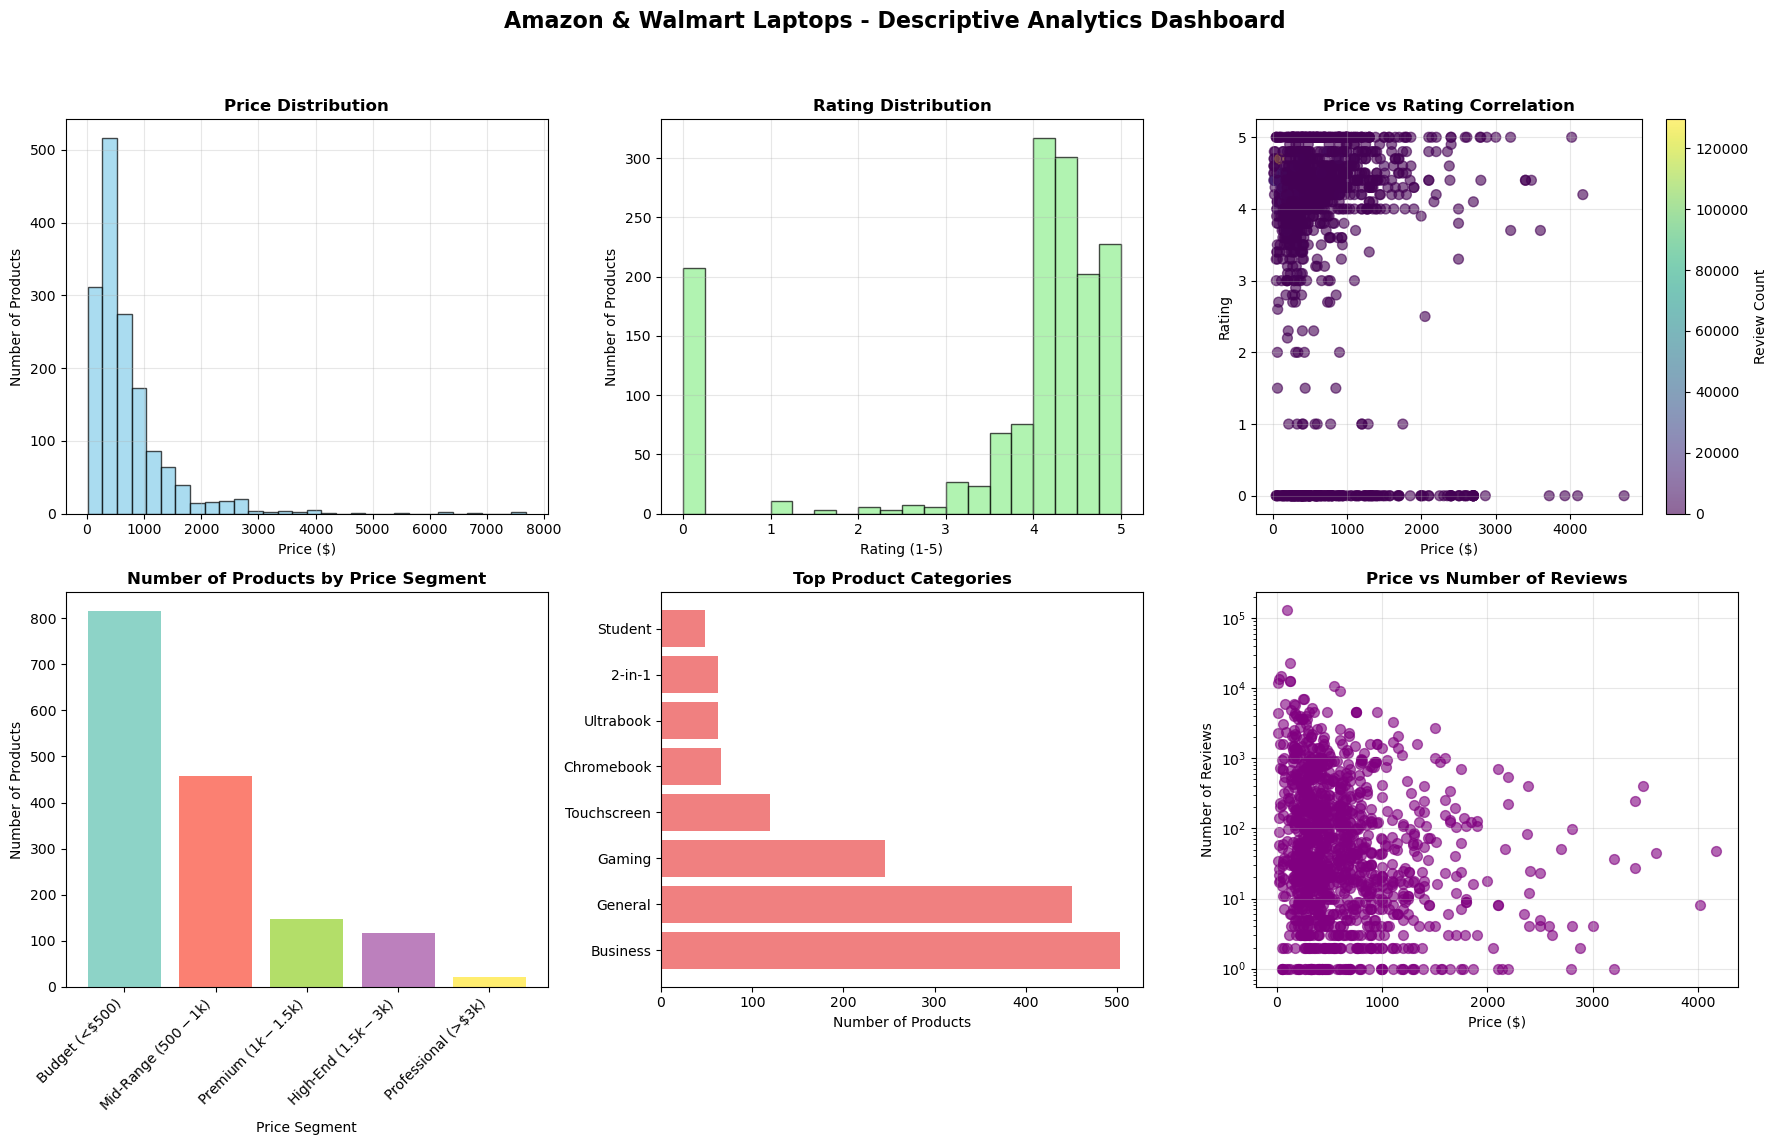


📊 DATA SUMMARY:
Total products: 1558
Products with ratings: 1485
Products with prices: 1558
Products with reviews: 1558

Average price: $708.67
Average rating: 3.66

💰 PRICE SEGMENT DISTRIBUTION:
  Budget (<$500): 816 products (52.4%)
  Mid-Range ($500-$1k): 457 products (29.3%)
  Premium ($1k-$1.5k): 147 products (9.4%)
  High-End ($1.5k-$3k): 117 products (7.5%)
  Professional (>$3k): 20 products (1.3%)

📦 PRODUCT CATEGORY DISTRIBUTION:
  Business: 503 products (32.3%)
  General: 450 products (28.9%)
  Gaming: 246 products (15.8%)
  Touchscreen: 119 products (7.6%)
  Chromebook: 66 products (4.2%)
  Ultrabook: 63 products (4.0%)
  2-in-1: 63 products (4.0%)
  Student: 48 products (3.1%)

🏷️ TOP BRANDS:
  HP: 435 products (27.9%)
  Lenovo: 219 products (14.1%)
  Dell: 213 products (13.7%)
  ASUS: 139 products (8.9%)
  N/A: 108 products (6.9%)
  Apple: 100 products (6.4%)
  Acer: 79 products (5.1%)
  Microsoft: 71 products (4.6%)
  MSI: 47 products (3.0%)
  acer: 30 products (1.9%)

🛒

In [74]:
def prepare_data_for_visualization(df):
    """Prepare the combined dataframe for visualization"""
    df = df.copy()
    
    # 1. Convert rating to numeric (handle 'N/A' values)
    df['rating_numeric'] = pd.to_numeric(df['rating'], errors='coerce')
    
    # 2. Convert reviews to numeric
    def parse_reviews(review_str):
        if pd.isna(review_str) or review_str == 'N/A':
            return 0
        if isinstance(review_str, (int, float)):
            return float(review_str)
        if isinstance(review_str, str):
            # Remove commas and any non-numeric characters
            review_str = review_str.replace(',', '')
            try:
                return float(review_str)
            except:
                return 0
        return 0
    
    df['reviews_numeric'] = df['reviews'].apply(parse_reviews)
    # 3. Create price segments
    # This will automatically skip NaN values
    # Function definition - everything indented
    def categorize_price(price, bins=[0, 500, 1000, 1500, 3000, float('inf')], 
                         labels=["Budget (<$500)", "Mid-Range ($500-$1k)", 
                                "Premium ($1k-$1.5k)", "High-End ($1.5k-$3k)", 
                                "Professional (>$3k)"]):
        """
        Categorize price into segments.
        """
        if pd.isna(price) or price <= 0:
            return 'Unknown'
        
        for i in range(len(bins)-1):
            if bins[i] <= price < bins[i+1]:
                return labels[i]
        
    
    # Apply function - NOT indented (outside function)
    df['price_segment'] = df['extracted_price'].apply(categorize_price)
    
    # 4. Create product categories based on title
    def categorize_product(title):
        if not isinstance(title, str):
            return 'Other'
        
        title_lower = title.lower()
        
        if 'gaming' in title_lower:
            return 'Gaming'
        elif 'business' in title_lower or 'work' in title_lower or 'office' in title_lower:
            return 'Business'
        elif 'student' in title_lower or 'school' in title_lower or 'education' in title_lower:
            return 'Student'
        elif 'ultrabook' in title_lower or 'ultra-thin' in title_lower or 'thin' in title_lower:
            return 'Ultrabook'
        elif '2-in-1' in title_lower or 'convertible' in title_lower:
            return '2-in-1'
        elif 'chromebook' in title_lower:
            return 'Chromebook'
        elif 'touchscreen' in title_lower or 'touch screen' in title_lower:
            return 'Touchscreen'
        else:
            return 'General'
    
    df['product_category'] = df['title'].apply(categorize_product)
    
    return df

def create_analytical_visualizations(df):
    """Create visualizations for descriptive analytics"""
    print("=" * 70)
    print("DESCRIPTIVE ANALYTICS - DATA VISUALIZATION")
    print("=" * 70)
    
    # First prepare the data
    df = prepare_data_for_visualization(df)
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Amazon & Walmart Laptops - Descriptive Analytics Dashboard', 
                fontsize=16, fontweight='bold')
    
    # 1. Price Distribution (with log scale for better visualization)
    price_data = df['extracted_price'].dropna()
    if len(price_data) > 0:
        axes[0, 0].hist(price_data[price_data > 0], bins=30, alpha=0.7, 
                       color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Price Distribution', fontweight='bold')
        axes[0, 0].set_xlabel('Price ($)')
        axes[0, 0].set_ylabel('Number of Products')
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No price data available', 
                       ha='center', va='center', fontsize=12)
        axes[0, 0].set_title('Price Distribution', fontweight='bold')
    
    # 2. Rating Distribution (only show products with ratings)
    rating_data = df['rating_numeric'].dropna()
    if len(rating_data) > 0:
        axes[0, 1].hist(rating_data, bins=20, alpha=0.7, 
                       color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('Rating Distribution', fontweight='bold')
        axes[0, 1].set_xlabel('Rating (1-5)')
        axes[0, 1].set_ylabel('Number of Products')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No rating data available', 
                       ha='center', va='center', fontsize=12)
        axes[0, 1].set_title('Rating Distribution', fontweight='bold')
    
    # 3. Price vs Rating Scatter Plot (only valid data)
    valid_data = df[(df['rating_numeric'].notna()) & 
                   (df['extracted_price'] > 0) & 
                   (df['extracted_price'] < 5000)]  # Remove extreme outliers
    if len(valid_data) > 0:
        scatter = axes[0, 2].scatter(valid_data['extracted_price'], 
                                    valid_data['rating_numeric'], 
                                    c=valid_data['reviews_numeric'], 
                                    cmap='viridis', alpha=0.6, s=50)
        axes[0, 2].set_title('Price vs Rating Correlation', fontweight='bold')
        axes[0, 2].set_xlabel('Price ($)')
        axes[0, 2].set_ylabel('Rating')
        axes[0, 2].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, 2], label='Review Count')
    else:
        axes[0, 2].text(0.5, 0.5, 'No valid price/rating data', 
                       ha='center', va='center', fontsize=12)
        axes[0, 2].set_title('Price vs Rating Correlation', fontweight='bold')
    
   # 4. Price Segments Comparison (excluding NaN)
    # Filter out NaN values
    valid_mask = (df['price_segment'] != 'Unknown') & (df['extracted_price'] > 0)
    valid_df = df[valid_mask]

    price_segment_counts = valid_df['price_segment'].value_counts()
    
    if len(price_segment_counts) > 0:
        colors = plt.cm.Set3(np.linspace(0, 1, len(price_segment_counts)))
        bars = axes[1, 0].bar(price_segment_counts.index, price_segment_counts.values, 
                             color=colors)
        axes[1, 0].set_title('Number of Products by Price Segment', fontweight='bold')
        axes[1, 0].set_xlabel('Price Segment')
        axes[1, 0].set_ylabel('Number of Products')
        axes[1, 0].set_xticklabels(price_segment_counts.index, rotation=45, ha='right')
    else:
        axes[1, 0].text(0.5, 0.5, 'No valid price segment data', 
                       ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('Number of Products by Price Segment', fontweight='bold')
    
    # 5. Product Category Analysis
    top_categories = df['product_category'].value_counts().head(8)
    if len(top_categories) > 0:
        axes[1, 1].barh(range(len(top_categories)), top_categories.values, 
                       color='lightcoral')
        axes[1, 1].set_title('Top Product Categories', fontweight='bold')
        axes[1, 1].set_xlabel('Number of Products')
        axes[1, 1].set_yticks(range(len(top_categories)))
        axes[1, 1].set_yticklabels(top_categories.index)
    else:
        axes[1, 1].text(0.5, 0.5, 'No category data', 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Top Product Categories', fontweight='bold')
    
    # 6. Reviews vs Price (with log scale for reviews)
    review_price_data = df[(df['extracted_price'] > 0) & 
                          (df['extracted_price'] < 5000) &
                          (df['reviews_numeric'] > 0)]
    if len(review_price_data) > 0:
        scatter = axes[1, 2].scatter(review_price_data['extracted_price'], 
                                    review_price_data['reviews_numeric'], 
                                    alpha=0.6, color='purple', s=50)
        axes[1, 2].set_title('Price vs Number of Reviews', fontweight='bold')
        axes[1, 2].set_xlabel('Price ($)')
        axes[1, 2].set_ylabel('Number of Reviews')
        axes[1, 2].set_yscale('log')  # Log scale for better visualization
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'No valid price/review data', 
                       ha='center', va='center', fontsize=12)
        axes[1, 2].set_title('Price vs Number of Reviews', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Print some statistics
    print("\n📊 DATA SUMMARY:")
    print(f"Total products: {len(df)}")
    print(f"Products with ratings: {df['rating_numeric'].notna().sum()}")
    print(f"Products with prices: {df['extracted_price'].notna().sum()}")
    print(f"Products with reviews: {df['reviews_numeric'].notna().sum()}")
    
    # Calculate and display averages
    avg_price = df['extracted_price'].mean()
    avg_rating = df['rating_numeric'].mean()
    
    if not pd.isna(avg_price):
        print(f"\nAverage price: ${avg_price:.2f}")
    if not pd.isna(avg_rating):
        print(f"Average rating: {avg_rating:.2f}")
    
    # Price segment distribution
    print("\n💰 PRICE SEGMENT DISTRIBUTION:")
    for segment, count in price_segment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {segment}: {count} products ({percentage:.1f}%)")
    
    # Category distribution
    print("\n📦 PRODUCT CATEGORY DISTRIBUTION:")
    for category, count in top_categories.items():
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count} products ({percentage:.1f}%)")
    
    # Brand analysis
    print("\n🏷️ TOP BRANDS:")
    top_brands = df['brand_final'].value_counts().head(10)
    for brand, count in top_brands.items():
        percentage = (count / len(df)) * 100
        print(f"  {brand}: {count} products ({percentage:.1f}%)")
    
    # Source analysis
    if 'source' in df.columns:
        print("\n🛒 SOURCE DISTRIBUTION:")
        source_counts = df['source'].value_counts()
        for source, count in source_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {source}: {count} products ({percentage:.1f}%)")
    
    return df  # Return the prepared dataframe

# Create visualizations
prepared_df = create_analytical_visualizations(combined_df)

Data points for analysis: 1484
Price range: $13.99 - $7506.24
Rating range: 0.00 - 5.00


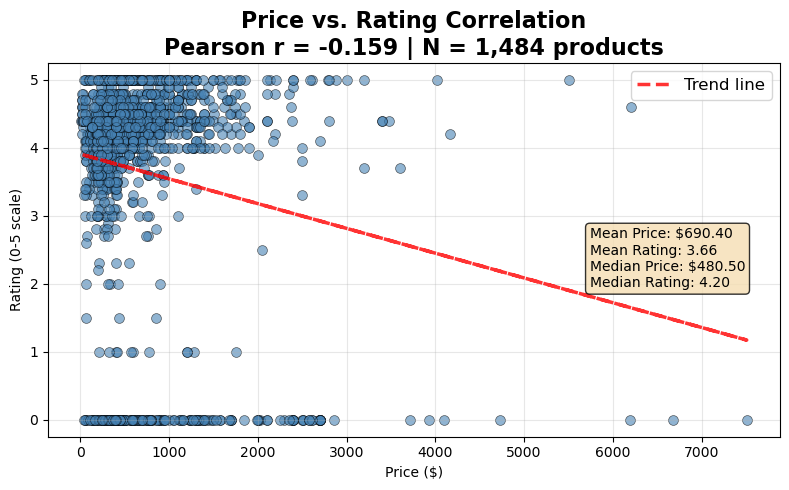


DETAILED STATISTICS
Total products analyzed: 1,484
Correlation coefficient: -0.1586
Price - Mean: $690.40
Price - Median: $480.50
Price - Std Dev: $684.23
Rating - Mean: 3.658
Rating - Median: 4.200
Rating - Std Dev: 1.573


In [93]:
# ====================== Price Vs Rating correlation ===============
# Create a clean DataFrame with only valid values
plot_df = prepared_df.dropna(subset=['extracted_price', 'rating_numeric'])
plot_df = plot_df[(plot_df['extracted_price'] > 0) & 
                  (plot_df['rating_numeric'] >= 0) & 
                  (plot_df['rating_numeric'] <= 5)]

print(f"Data points for analysis: {len(plot_df)}")
print(f"Price range: ${plot_df['extracted_price'].min():.2f} - ${plot_df['extracted_price'].max():.2f}")
print(f"Rating range: {plot_df['rating_numeric'].min():.2f} - {plot_df['rating_numeric'].max():.2f}")

# Create scatter plot
plt.figure(figsize=(8, 5))

# Plot the data
scatter = plt.scatter(plot_df['extracted_price'], plot_df['rating_numeric'], 
                     alpha=0.6, s=50, c='steelblue', edgecolor='black', linewidth=0.5)

# Add regression line
if len(plot_df) > 1:
    z = np.polyfit(plot_df['extracted_price'], plot_df['rating_numeric'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['extracted_price'], p(plot_df['extracted_price']), 
            "r--", linewidth=2.5, alpha=0.8, label=f'Trend line')

# Calculate correlation
correlation = plot_df['extracted_price'].corr(plot_df['rating_numeric'])

# Set labels and title
plt.xlabel('Price ($)', fontsize=10)
plt.ylabel('Rating (0-5 scale)', fontsize=10)
plt.title(f'Price vs. Rating Correlation\nPearson r = {correlation:.3f} | N = {len(plot_df):,} products', 
          fontsize=16, fontweight='bold')

# Add grid and legend
plt.grid(True, alpha=0.3)
if len(plot_df) > 1:
    plt.legend(fontsize=12)

# Add some statistics as text
stats_text = f'Mean Price: ${plot_df["extracted_price"].mean():.2f}\n'
stats_text += f'Mean Rating: {plot_df["rating_numeric"].mean():.2f}\n'
stats_text += f'Median Price: ${plot_df["extracted_price"].median():.2f}\n'
stats_text += f'Median Rating: {plot_df["rating_numeric"].median():.2f}'

plt.text(0.74, 0.56, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print("DETAILED STATISTICS")
print(f"{'='*60}")
print(f"Total products analyzed: {len(plot_df):,}")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"Price - Mean: ${plot_df['extracted_price'].mean():.2f}")
print(f"Price - Median: ${plot_df['extracted_price'].median():.2f}")
print(f"Price - Std Dev: ${plot_df['extracted_price'].std():.2f}")
print(f"Rating - Mean: {plot_df['rating_numeric'].mean():.3f}")
print(f"Rating - Median: {plot_df['rating_numeric'].median():.3f}")
print(f"Rating - Std Dev: {plot_df['rating_numeric'].std():.3f}")

## Data insights

In [42]:
def generate_project_insights(df):
    """Generate key insights for the project report"""
    print("=" * 70)
    print("KEY INSIGHTS AND CONCLUSIONS")
    print("=" * 70)
    
    # Prepare data if needed
    if 'rating_numeric' not in df.columns or 'price_segment' not in df.columns:
        df = prepare_data_for_visualization(df)
    
    # Calculate key metrics
    total_products = len(df)
    
    # Price metrics
    avg_price = df['extracted_price'].mean()
    median_price = df['extracted_price'].median()
    min_price = df['extracted_price'].min()
    max_price = df['extracted_price'].max()
    
    # Rating metrics
    rating_data = df['rating_numeric'].dropna()
    avg_rating = rating_data.mean() if len(rating_data) > 0 else None
    total_products_with_ratings = len(rating_data)
    
    # Reviews metrics
    reviews_data = df['reviews_numeric'].dropna()
    total_reviews = reviews_data.sum()
    avg_reviews_per_product = reviews_data.mean() if len(reviews_data) > 0 else 0
    
    # Price segments distribution
    price_segment_counts = df['price_segment'].value_counts()
    
    # Source analysis
    source_counts = df['source'].value_counts()
    amazon_count = source_counts.get('Amazon', 0)
    walmart_count = source_counts.get('Walmart', 0)
    
    # Brand analysis
    brand_counts = df['brand_final'].value_counts()
    top_5_brands = brand_counts.head(5)
    generic_brands = brand_counts.get('N/A', 0) + brand_counts.get('NIMO', 0)
    
    # Category analysis
    category_counts = df['product_category'].value_counts()
    top_category = category_counts.index[0] if len(category_counts) > 0 else "N/A"
    
    # Price by source
    price_by_source = df.groupby('source')['extracted_price'].mean()
    amazon_avg_price = price_by_source.get('Amazon', 0)
    walmart_avg_price = price_by_source.get('Walmart', 0)
    
    print("📊 EXECUTIVE SUMMARY:")
    print(f"• Analyzed {total_products:,} products from Amazon ({amazon_count:,}) and Walmart ({walmart_count:,})")
    print(f"• Price range: ${min_price:.2f} to ${max_price:,.2f}")
    print(f"• Average price: ${avg_price:.2f} | Median: ${median_price:.2f}")
    
    if avg_rating:
        print(f"• Average rating: {avg_rating:.2f}/5.0 ({total_products_with_ratings:,} products with ratings)")
    print(f"• Total reviews analyzed: {total_reviews:,.0f} ({avg_reviews_per_product:.1f} avg per product)")
    
    print("\n🔍 KEY MARKET FINDINGS:")
    
    # 1. Price Segment Analysis
    print("\n1. PRICE SEGMENTATION:")
    for segment, count in price_segment_counts.items():
        percentage = (count / total_products) * 100
        print(f"   • {segment}: {count:,} products ({percentage:.1f}%)")
    
    # 2. Source Comparison
    print(f"\n2. MARKETPLACE COMPARISON:")
    print(f"   • Amazon has {amazon_avg_price - walmart_avg_price:.2f} higher average price")
    print(f"   • Amazon: ${amazon_avg_price:.2f} avg | Walmart: ${walmart_avg_price:.2f} avg")
    
    # 3. Brand Analysis
    print(f"\n3. BRAND LANDSCAPE:")
    print(f"   • Top 5 brands represent {(top_5_brands.sum() / total_products * 100):.1f}% of market")
    print(f"   • Generic/unknown brands: {generic_brands:,} products ({(generic_brands/total_products*100):.1f}%)")
    print(f"   • Top brands by product count:")
    for brand, count in top_5_brands.items():
        percentage = (count / total_products) * 100
        print(f"     - {brand}: {count:,} products ({percentage:.1f}%)")
    
    # 4. Category Analysis
    print(f"\n4. PRODUCT CATEGORY DOMINANCE:")
    print(f"   • Most common category: {top_category} ({category_counts.get(top_category, 0):,} products)")
    print(f"   • Category distribution:")
    for category, count in category_counts.head(5).items():
        percentage = (count / total_products) * 100
        print(f"     - {category}: {count:,} products ({percentage:.1f}%)")
    
    # 5. Price vs Rating Insights
    if avg_rating:
        print(f"\n5. PRICE-QUALITY RELATIONSHIP:")
        # Calculate correlation if we have enough data
        valid_data = df[(df['rating_numeric'].notna()) & (df['extracted_price'] > 0)]
        if len(valid_data) > 10:
            correlation = valid_data['extracted_price'].corr(valid_data['rating_numeric'])
            print(f"   • Price-Rating correlation: {correlation:.3f}")
            if correlation > 0.3:
                print("   • INSIGHT: Higher prices tend to correlate with higher ratings")
            elif correlation < -0.3:
                print("   • INSIGHT: Lower prices tend to correlate with higher ratings")
            else:
                print("   • INSIGHT: Price and rating show weak correlation")
    
    # 6. Value Proposition Analysis
    print(f"\n6. VALUE PROPOSITION ANALYSIS:")
    
    # Find products with best value (high rating, reasonable price)
    if avg_rating:
        value_products = df[(df['rating_numeric'] >= 4.0) & 
                           (df['extracted_price'] <= 500) &
                           (df['reviews_numeric'] >= 50)]
        print(f"   • {len(value_products):,} products offer great value (rating ≥4.0, price ≤$500, ≥50 reviews)")
    
    # 7. Market Opportunities
    print(f"\n7. MARKET OPPORTUNITIES:")
    
    # Identify gaps in the market
    premium_high_rating = df[(df['price_segment'].isin(['Premium', 'High-end'])) & 
                            (df['rating_numeric'] < 3.5)]
    budget_high_rating = df[(df['price_segment'] == 'Budget (< $300)') & 
                           (df['rating_numeric'] >= 4.0)]
    
    print(f"   • {len(premium_high_rating):,} premium products have ratings below 3.5 (quality concerns)")
    print(f"   • {len(budget_high_rating):,} budget products maintain high ratings (≥4.0) - great value segment")


# Generate insights
generate_project_insights(prepared_df)

KEY INSIGHTS AND CONCLUSIONS
📊 EXECUTIVE SUMMARY:
• Analyzed 1,558 products from Amazon (943) and Walmart (615)
• Price range: $0.00 to $7,678.99
• Average price: $708.67 | Median: $492.50
• Average rating: 3.66/5.0 (1,485 products with ratings)
• Total reviews analyzed: 638,091 (409.6 avg per product)

🔍 KEY MARKET FINDINGS:

1. PRICE SEGMENTATION:
   • Mid-range ($300-$700): 634 products (40.7%)
   • Budget (< $300): 408 products (26.2%)
   • Premium ($700-$1500): 378 products (24.3%)
   • High-end (> $1500): 137 products (8.8%)
   • Unknown: 1 products (0.1%)

2. MARKETPLACE COMPARISON:
   • Amazon has -19.00 higher average price
   • Amazon: $701.18 avg | Walmart: $720.17 avg

3. BRAND LANDSCAPE:
   • Top 5 brands represent 71.5% of market
   • Generic/unknown brands: 113 products (7.3%)
   • Top brands by product count:
     - HP: 435 products (27.9%)
     - Lenovo: 219 products (14.1%)
     - Dell: 213 products (13.7%)
     - ASUS: 139 products (8.9%)
     - N/A: 108 products (6.

# WEB SCRAPPING COMPLETED 